# Problem definition

Given an undirected graph, ﬁnd the largest subset of vertices in which no two are connected by an edge.

energy function: $$H=H_{A}+H_{B}$$
where
$$H_{A}=A \sum_{i j \in E} x_{i} x_{j}$$
and
$$H_{B}=-B \sum_{i} x_{i}$$

$H_A$ is constraint violation and $H_B$ is cost. Here $x_{i}\in\{0,1\}$.

# import packages

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.functional import gumbel_softmax

# np.random.seed(2050)
# torch.manual_seed(2050)

%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Code

In [2]:
def load_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    G = nx.from_dict_of_lists(data)
    return G

# def load_graph(filename):
#     G = nx.Graph() # undirected graphs
#     for line in open(filename):
#         strlist = line.split(',')
#         n1 = int(strlist[0])
#         n2 = int(strlist[1])
#         G.add_edges_from([(n1, n2)])
#     return G


def train(G, init_tau=10, final_tau=1, hard=False, 
          drop_temp=True, lr=1e-1, eta=1, max_iters=5000):
    
    n=G.number_of_nodes()
    A = nx.adjacency_matrix(G)
    A = torch.from_numpy(A.todense())
    A = A.type(torch.float32)
    
    # set parameters
    if use_cuda:
        A = A.cuda()
        x = torch.randn(n, 1, device='cuda')*1e-5
        x.requires_grad = True
    else:
        x = torch.randn(n, 1, requires_grad=True)*1e-5

    # set optimizer
    optimizer = torch.optim.SGD([x], lr=lr)
#     optimizer = torch.optim.Adam([x], lr=lr)

    tau=init_tau
    minus_temp = (init_tau - final_tau) / max_iters
    cost_arr = []
    
    for iters in range(max_iters):
        optimizer.zero_grad()
        if use_cuda:
            probs = torch.empty(n, 2, device='cuda')
        else:
            probs = torch.empty(n, 2)
        p = torch.sigmoid(x)
        probs[:, 0] = p.squeeze()
        probs[:, -1] = 1-probs[:, 0]
        logits = torch.log(probs+1e-10)  # [n,2]
        s = gumbel_softmax(logits, tau=tau, hard=hard)  # [n,2]
        s = s[:, 0]
        s = torch.unsqueeze(s, 1)
        cost = -torch.sum(s)
        constraint = s.t()@A@s
        loss = cost+eta*constraint
        loss.backward()
        optimizer.step()
        if drop_temp:
            tau -= minus_temp
        
        with torch.no_grad():
            s=gumbel_softmax(logits,tau=tau,hard=True) #[n,2]
            s=s[:,0]
            s=torch.unsqueeze(s,1)
            constraint=s.t()@A@s
            if constraint == 0:
                cost=-torch.sum(s)
                cost_arr.append(cost.cpu())
    print(len(cost_arr))
    return cost_arr

# Experiments on real-world networks

## Cora

In [3]:
# G=load_graph('./data/cora.edges')
G=load_data('./data/ind.cora.graph')
print(G.number_of_nodes(), G.number_of_edges())

2708 5278


In [4]:
# cost=train(G, lr=1, max_iters=20000)
cost=train(G, init_tau=1,hard=True,drop_temp=False, lr=1e-2, eta=15, max_iters=20000)
print(min(cost))

TypeError: can't convert np.ndarray of type numpy.int32. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

## Citeseer

In [34]:
G=load_graph('./data/citeseer.edges')
print(G.number_of_nodes(), G.number_of_edges())

3264 4536


In [10]:
G = nx.grid_2d_graph(3, 3)
cost=train(G, init_tau=1,hard=True,drop_temp=False, lr=1e-2, eta=15, max_iters=2000)
print(min(cost))
# G = nx.grid

1939
tensor(-5.)


# Gumbel-softmax optimization

## N parameters

In [7]:
%%time

# G = load_graph('./data/cora.edges')
G = nx.grid_2d_graph(10, 10, periodic=False)
n = G.number_of_nodes()
max_iters = 40000
lr = 1e-2
tau = 0.5
eta = 15

torch.manual_seed(1)

A = nx.adjacency_matrix(G)
A = torch.from_numpy(A.todense())
A = A.type(torch.float32)

# set parameters
if use_cuda:
    A = A.cuda()
    x = torch.randn(n, 1, device='cuda')*1e-5
    x.requires_grad = True
else:
    x = torch.randn(n, 1, requires_grad=True)*1e-5

# set optimizer
optimizer = torch.optim.SGD([x], lr=lr)

# log
cost_arr = []
constrain_arr = []

for i in range(max_iters):
    optimizer.zero_grad()
    if use_cuda:
        probs = torch.empty(n, 2, device='cuda')
    else:
        probs = torch.empty(n, 2)
    p = torch.sigmoid(x)
    probs[:, 0] = p.squeeze()
    probs[:, -1] = 1-probs[:, 0]
    logits = torch.log(probs+1e-10)  # [n,2]
    s = gumbel_softmax(logits, tau=tau, hard=True)  # [n,2]
    s = s[:, 0]
#     print(s.size())
    s = torch.unsqueeze(s, 1)
#     print(s.size())
    cost = -torch.sum(s)
    constraint = s.t()@A@s

    loss = cost+eta*constraint
    loss.backward()
    optimizer.step()
    with torch.no_grad():
#         s=gumbel_softmax(logits,tau=tau,hard=True) #[n,2]
#         s=s[:,0]
#     #     print(s.size())
#         s=torch.unsqueeze(s,1)
#     #     print(s.size())
#         cost=-torch.sum(s)
#         constraint=s.t()@A@s
        if constraint == 0:
            cost_arr.append(cost.cpu())
#         constrain_arr.append(constraint.cpu())

CPU times: user 1min 9s, sys: 1.18 s, total: 1min 10s
Wall time: 1min 10s


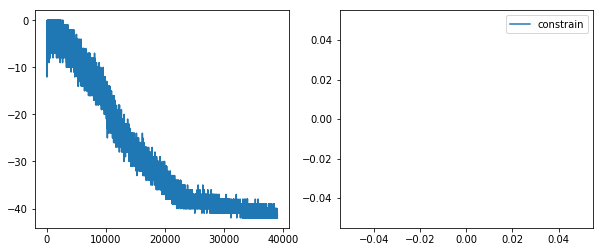

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(cost_arr, label='cost')
plt.subplot(122)
plt.plot(constrain_arr, label='constrain')
plt.legend()

## k * N parameters

In [23]:
%%time

G = load_graph('./data/cora.edges')
n = G.number_of_nodes()
max_iters = 5000
lr = 1e-2
tau = 1
eta = 5

torch.manual_seed(1)

A = nx.adjacency_matrix(G)
A = torch.from_numpy(A.todense())
A = A.type(torch.float32)

# set parameters
if use_cuda:
    A = A.cuda()
    x=torch.rand(5,1,device='cuda')
    W=torch.randn(n,5,device='cuda')*1e-5
#     x = torch.randn(n, 1, device='cuda')*1e-5
    W.requires_grad = True
else:
    x = torch.randn(5, 1)
    W = torch.randn(n,1,requires_grad=True)

# set optimizer
optimizer = torch.optim.RMSprop([W], lr=lr)

# log
cost_arr = []
constrain_arr = []

for i in range(max_iters):
    optimizer.zero_grad()
    if use_cuda:
        probs = torch.empty(n, 2, device='cuda')
    else:
        probs = torch.empty(n, 2)
    p = torch.sigmoid(W@x)
    probs[:, 0] = p.squeeze()
    probs[:, -1] = 1-probs[:, 0]
    logits = torch.log(probs+1e-10)  # [n,2]
    s = gumbel_softmax(logits, tau=tau, hard=True)  # [n,2]
    s = s[:, 0]
#     print(s.size())
    s = torch.unsqueeze(s, 1)
#     print(s.size())
    cost = -torch.sum(s)
    constraint = s.t()@A@s

    loss = cost+eta*constraint
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        #         s=gumbel_softmax(logits,tau=tau,hard=True) #[n,2]
        #         s=s[:,0]
        #     #     print(s.size())
        #         s=torch.unsqueeze(s,1)
        #     #     print(s.size())
        #         cost=-torch.sum(s)
        #         constraint=s.t()@A@s

        cost_arr.append(cost.cpu())
        constrain_arr.append(constraint.cpu())

CPU times: user 7.33 s, sys: 325 ms, total: 7.66 s
Wall time: 7.95 s


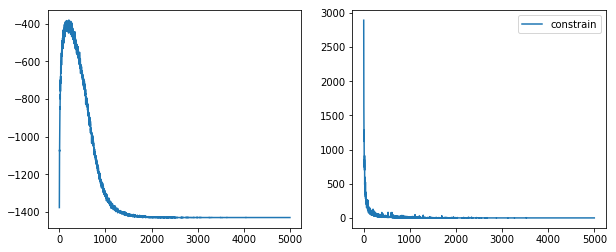

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(cost_arr, label='cost')
plt.subplot(122)
plt.plot(constrain_arr, label='constrain')
plt.legend()

In [25]:
cost_arr[-20:-1]

[tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.),
 tensor(-1430.)]

## test on disjoint graphs

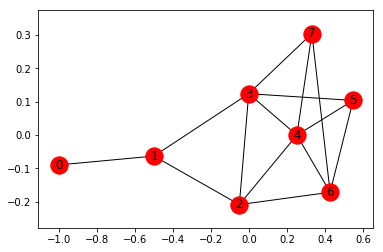

In [47]:
G = nx.Graph()

G.add_edges_from([(0,1),(1,3),(1,2),(2,3),(3,5),(3,4),(2,6),(2,4),(4,5),(5,6),(3,7),(4,7),(6,7),(4,6)])

nx.draw_networkx(G)

In [48]:
%%time

# G = createGraph('./data/cora.edges')
# G = nx.Graph()

# G.add_edges_from([(0,1),(1,2),(3,4),(4,5)])

n = G.number_of_nodes()
max_iters = 2000
lr = 1e-1
tau = 1
eta = 5

# torch.manual_seed(1)
A = nx.adjacency_matrix(G)
A = torch.from_numpy(A.todense())
A = A.type(torch.float32)

# set parameters
if use_cuda:
    A = A.cuda()
    x = torch.randn(n, 1, device='cuda')*1e-5
    x.requires_grad = True
else:
    x = torch.randn(n, 1, requires_grad=True)*1e-5

# set optimizer
optimizer = torch.optim.SGD([x], lr=lr)

# log
cost_arr = []
constrain_arr = []

for i in range(max_iters):
    optimizer.zero_grad()
    if use_cuda:
        probs = torch.empty(n, 2, device='cuda')
    else:
        probs = torch.empty(n, 2)
    p = torch.sigmoid(x)
    probs[:, 0] = p.squeeze()
    probs[:, -1] = 1-probs[:, 0]
    logits = torch.log(probs+1e-10)  # [n,2]
    s = gumbel_softmax(logits, tau=tau, hard=True)  # [n,2]
    s = s[:, 0]
#     print(s.size())
    s = torch.unsqueeze(s, 1)
#     print(s.size())
    cost = -torch.sum(s)
    constraint = s.t()@A@s

    loss = cost+eta*constraint
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        #         s=gumbel_softmax(logits,tau=tau,hard=True) #[n,2]
        #         s=s[:,0]
        #     #     print(s.size())
        #         s=torch.unsqueeze(s,1)
        #     #     print(s.size())
        #         cost=-torch.sum(s)
        #         constraint=s.t()@A@s

        cost_arr.append(cost.cpu())
        constrain_arr.append(constraint.cpu())

CPU times: user 2.46 s, sys: 127 ms, total: 2.59 s
Wall time: 2.59 s


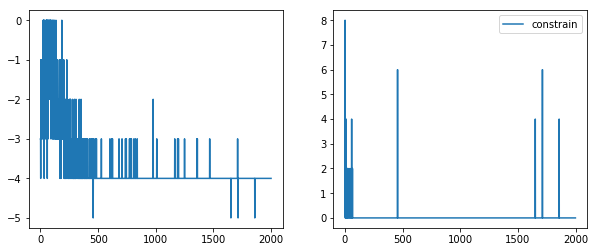

In [49]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(cost_arr, label='cost')
plt.subplot(122)
plt.plot(constrain_arr, label='constrain')
plt.legend()

In [50]:
s

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [51]:
with torch.no_grad():
    p=torch.sigmoid(x)

p[p>0.5]=1
p[p<0.5]=0

p=p.cpu().numpy().astype(np.int)
p.reshape(-1,)

partition = {}
for idx, n in enumerate(G.nodes()):
    partition[n] = int(p[idx])

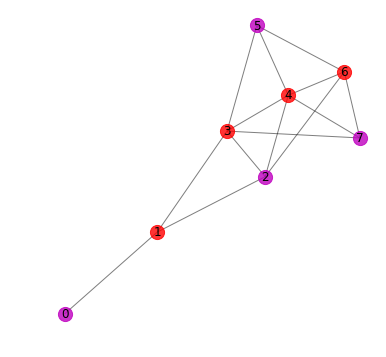

In [52]:
pos=nx.layout.spring_layout(G)
plt.figure(figsize=(6,6))
colors=["r",'m','b',"g",]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 200,
                                node_color = colors[com],alpha=0.8)

nx.draw_networkx_edges(G,pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
# q=community.modularity(partition,G)
# plt.text(0.5,1,"modularity=%.2f"%q,fontsize=20)
plt.show()

## visulize solution

In [58]:
# with torch.no_grad():
#     p=torch.sigmoid(x)

p[p>0.5]=1
p[p<0.5]=0
with torch.no_grad():
    p=p.cpu().numpy().astype(np.int)
p.reshape(-1,)

array([0, 0, 1, ..., 1, 0, 1])

In [59]:
partition = {}
for idx, n in enumerate(G.nodes()):
    partition[n] = int(p[idx])

In [60]:
subgraph_list=[]
for sub in nx.connected_component_subgraphs(G):
    subgraph_list.append(sub)

    
def plot_label(G, partition):
    pos=nx.layout.spring_layout(G)
    plt.figure(figsize=(5,5))
    colors=["r",'b']
    
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com and nodes in G.nodes()]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 200,
                                    node_color = colors[com],alpha=0.8)

    nx.draw_networkx_edges(G,pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off')
#     q=community.modularity(partition,G)
    # plt.text(0.5,1,"modularity=%.2f"%q,fontsize=20)
    plt.show()

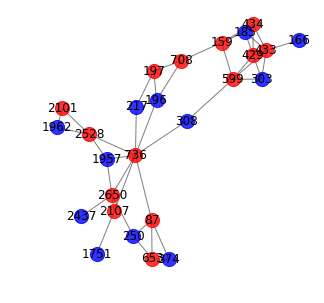

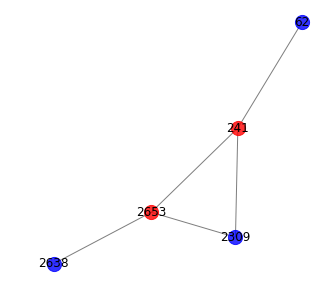

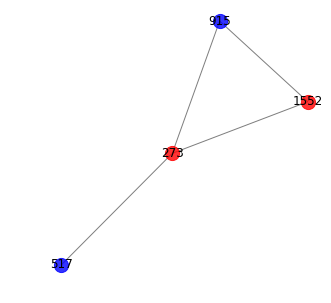

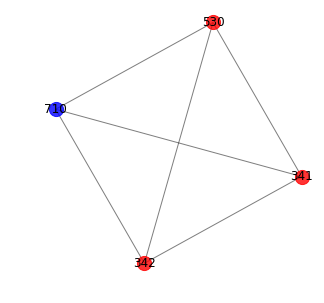

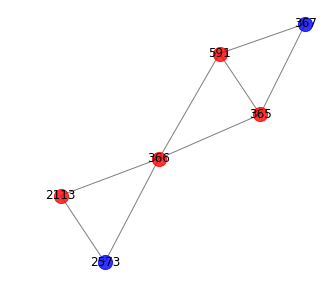

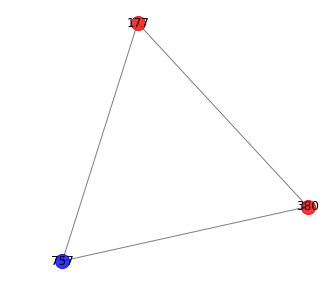

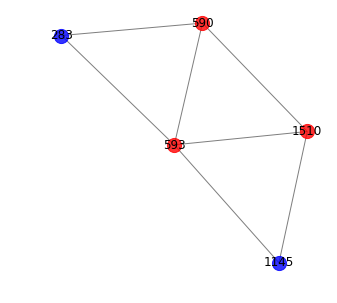

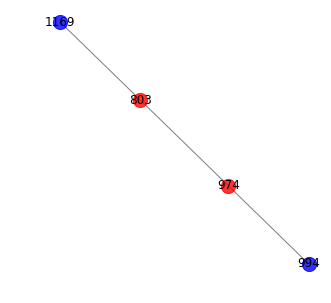

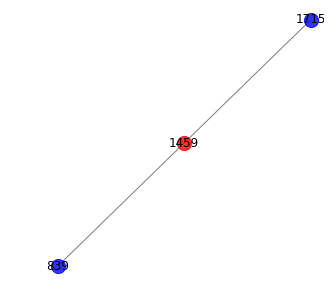

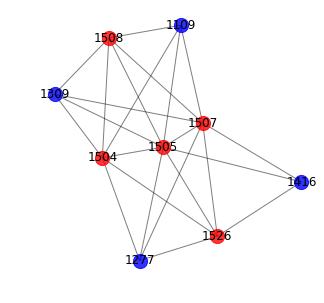

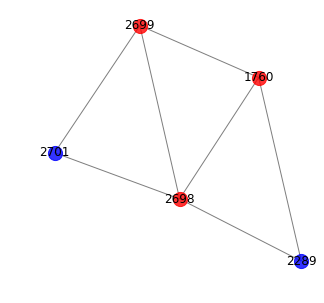

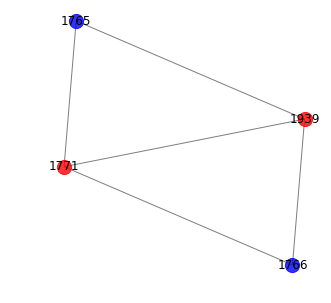

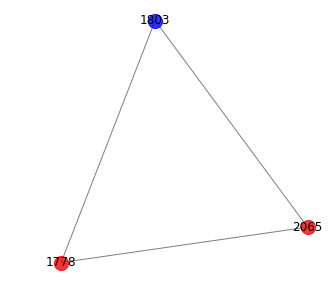

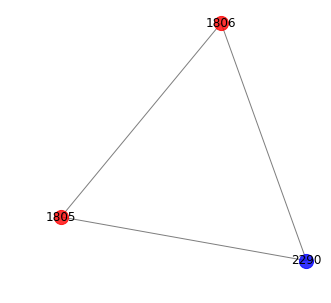

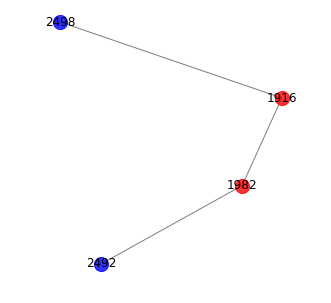

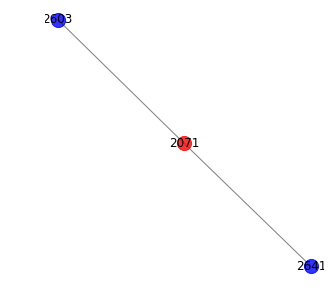

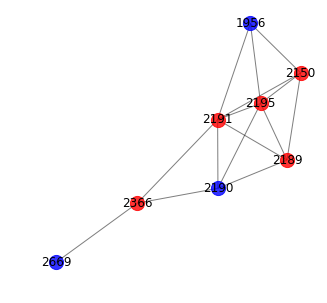

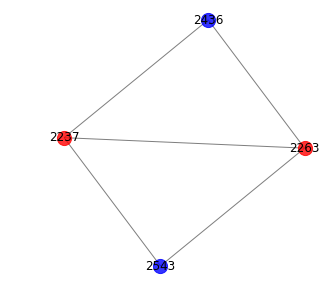

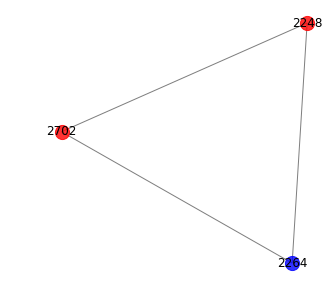

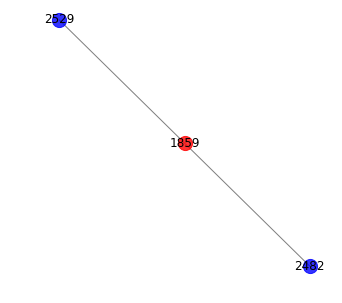

In [63]:
for i in range(len(subgraph_list)):
    if subgraph_list[i].number_of_nodes() > 100 or subgraph_list[i].number_of_nodes() <= 2 :
        pass
    else:
        plot_label(subgraph_list[i], partition)

# Batch version

In [2]:
from utils import gumbel_softmax_3d

In [3]:
bs = 128
n = 1024
x = torch.randn(bs, n, 1, device='cuda')*1e-5

In [4]:
if torch.cuda.is_available():
    probs = torch.empty(bs, n, 2, device='cuda')
else:
    probs = torch.empty(bs, n, 2)
p = torch.sigmoid(x)
probs[:, :, 0] = p.squeeze()
probs[:, :, -1] = 1-probs[:, :, 0]
logits = torch.log(probs+1e-10)
s = gumbel_softmax_3d(logits, tau=1, hard=True)
s = 2*s[:, :, 0]-1
s = torch.unsqueeze(s, -1)

In [5]:
s.size()

torch.Size([128, 1024, 1])

In [6]:
test = torch.sum(s, dim=1)
print(test.size())

torch.Size([128, 1])


In [11]:
idx = idx.reshape(-1,)

In [13]:
test[idx]

tensor([[  2.],
        [ -8.],
        [ -8.],
        [-40.]], device='cuda:0')

In [17]:
test[idx].cpu().min().numpy()

array(-40., dtype=float32)

In [7]:
torch.sum(s)

tensor(30., device='cuda:0')

In [8]:
s_t = torch.transpose(s, 1, 2)

In [9]:
s_t.size()

torch.Size([128, 1, 1024])

In [10]:
A = torch.randn(n, n, device='cuda')

In [12]:
results = s_t @ A @ s

In [ ]:
torch.squeeze

In [33]:
results.squeeze_().size()

torch.Size([128])

In [35]:
results = results.cpu().numpy()

In [7]:
results = np.random.randint(0,2, 10)

In [8]:
results

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [9]:
idx=np.argwhere(results==0)

In [10]:
len(idx)

4

In [26]:
a = torch.randint(0,2,(10,))

In [27]:
a

tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [32]:
constraint = constraint.numpy()

tensor([1, 1, 1, 1, 1, 1, 1])

In [20]:
s = torch.ones(10, 100, 1)
A = torch.ones(100, 100)

In [21]:
constraint = torch.squeeze(torch.transpose(s, 1, 2) @ A @ s)

In [22]:
constraint.size()

torch.Size([10])

In [23]:
constraint = constraint.cpu().numpy()
# idx = np.argwhere(constraint == 0) # select constraint=0
# print(idx.shape)

In [30]:
idx = np.argwhere(constraint == 10000) # select constraint=0

In [31]:
idx.shape

(10, 1)

In [32]:
cost = -1 * torch.sum(s, dim=1)

In [41]:
cost[idx.reshape(-1,)]

tensor([[-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.],
        [-100.]])

In [40]:
idx.reshape(-1,)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [37]:
idx

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [48]:
s = torch.randn(1024, 100, 4)
mod_mat = torch.randn(100,100)

In [47]:
torch.trace(s.t() @ mod_mat @ s)

tensor(39.1984)

In [49]:
temp = torch.transpose(s, 1, 2) @ mod_mat @ s

In [50]:
temp.size()

torch.Size([1024, 4, 4])

In [52]:
torch.trace(temp[0])

tensor(-145.9816)

In [54]:
torch.sum(torch.tensor[torch.trace(temp[i]) for i in range(temp.size()[0])])

TypeError: sum(): argument 'input' (position 1) must be Tensor, not list